In [1]:
# Module librairies
from pbc2dataset import PBC2DataSet
from utils import collate_fn_pre_padding

In [2]:
# External librairies
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
csvfilename = '../data/pbc2.csv'
dataset = PBC2DataSet(csvfilename=csvfilename)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn_pre_padding)

In [4]:
class LSTMBinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMBinaryClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

input_size = 8  # Each time step has 8 features
hidden_size = 50
num_layers = 2

model = LSTMBinaryClassifier(input_size, hidden_size, num_layers)

In [5]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 400
loss_tab = []
model.train()
for epoch in range(num_epochs):
    for sequences, labels in dataloader:
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss_tab.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/400], Loss: 0.6415
Epoch [2/400], Loss: 0.6972
Epoch [3/400], Loss: 0.5957
Epoch [4/400], Loss: 0.6919
Epoch [5/400], Loss: 0.4577
Epoch [6/400], Loss: 0.7758
Epoch [7/400], Loss: 0.6643
Epoch [8/400], Loss: 0.5213
Epoch [9/400], Loss: 0.6065
Epoch [10/400], Loss: 0.4850
Epoch [11/400], Loss: 0.5759
Epoch [12/400], Loss: 0.5261
Epoch [13/400], Loss: 0.5996
Epoch [14/400], Loss: 0.5485
Epoch [15/400], Loss: 0.5934
Epoch [16/400], Loss: 0.3672
Epoch [17/400], Loss: 0.5513
Epoch [18/400], Loss: 0.5041
Epoch [19/400], Loss: 0.5911
Epoch [20/400], Loss: 0.5986
Epoch [21/400], Loss: 0.4000
Epoch [22/400], Loss: 0.5780
Epoch [23/400], Loss: 0.6946
Epoch [24/400], Loss: 0.4991
Epoch [25/400], Loss: 0.5054
Epoch [26/400], Loss: 0.6293
Epoch [27/400], Loss: 0.7271
Epoch [28/400], Loss: 0.3670
Epoch [29/400], Loss: 0.5135
Epoch [30/400], Loss: 0.5361
Epoch [31/400], Loss: 0.2300
Epoch [32/400], Loss: 0.6133
Epoch [33/400], Loss: 0.4760
Epoch [34/400], Loss: 0.4058
Epoch [35/400], Loss: 0

In [6]:
model.eval()
with torch.no_grad():
    #test_dataset = PBC2DataSet(csvfilename='path/to/your/test_data.csv')
    #test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=pad_sequence)
    
    correct = 0
    total = 0
    for sequences, labels in dataloader:        
        outputs = model(sequences)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f'Test Accuracy: {correct / total:.4f}')

Test Accuracy: 0.9519


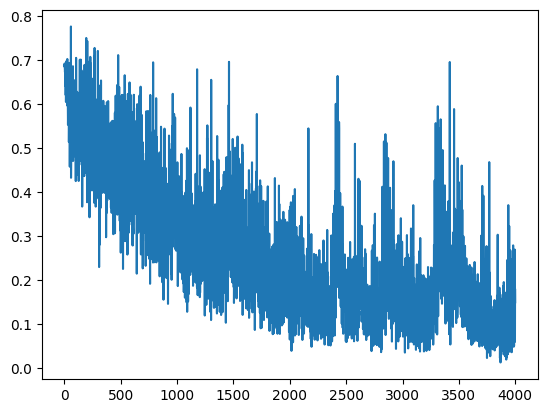

In [7]:
plt.plot(loss_tab)